Start by importing all the required libraries.

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from scipy.stats import pearsonr
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, mutual_info_regression

Load the train and test data

In [58]:
train_features = pd.read_csv("train_features.csv")
train_salaries = pd.read_csv("train_salaries.csv")
test_features = pd.read_csv("test_features.csv")

Explore the data.

In [59]:
train_features.head(3)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38


In [60]:
train_salaries.head(3)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137


Then join the features and target data

In [61]:
train_features = pd.merge(train_features,train_salaries,on="jobId")
train_features.head(3)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137


In [8]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [62]:
train_features.degree.unique()

array(['MASTERS', 'HIGH_SCHOOL', 'DOCTORAL', 'BACHELORS', 'NONE'],
      dtype=object)

The null values are present as None in the table (found by inspection of unique values in excel), so must convert them to get the null value count.

In [63]:
train_features.replace(to_replace='NONE', value=np.nan, inplace=True)

In [64]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               763146 non-null   object
 4   major                467645 non-null   object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


2 columns have null values in large amount, especially major has 50% misisng data.

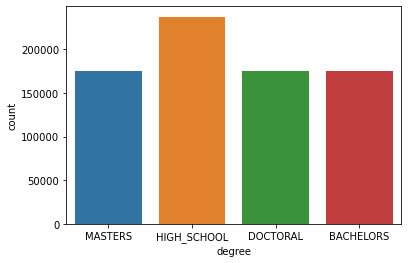

<Figure size 432x288 with 0 Axes>

In [65]:
degree_pcount = sns.countplot(x="degree",data=train_features)
plt.show()
plt.savefig("degree_distribution.png")

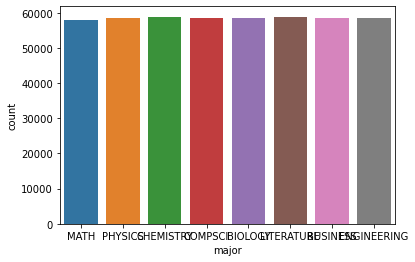

<Figure size 432x288 with 0 Axes>

In [66]:
major_pcount = sns.countplot(x="major",data=train_features)
plt.show()
plt.savefig("major_distribution.png")

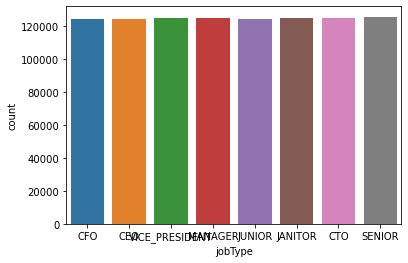

<Figure size 432x288 with 0 Axes>

In [67]:
jobtype_pcount = sns.countplot(x="jobType",data=train_features)
plt.show()
plt.savefig("jobtype_distribution.png")

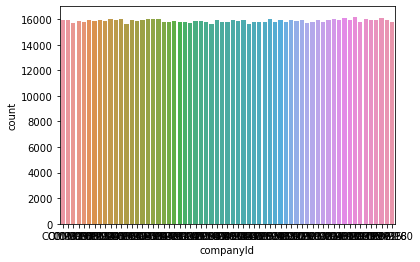

<Figure size 432x288 with 0 Axes>

In [68]:
company_pcount = sns.countplot(x="companyId",data=train_features)
plt.show()
plt.savefig("company_distribution.png")

It can be seen that most of data is equally distributed.

In [69]:
percentange_major_null = len(train_features[pd.isnull(train_features["major"])])/len(train_features)
percentage_degree_null = len(train_features[pd.isnull(train_features["degree"])])/len(train_features)

major_not_null = train_features[~pd.isnull(train_features["major"])]
degree_not_null = train_features[~pd.isnull(train_features["degree"])]

print(percentange_major_null, percentage_degree_null)

0.532355 0.236854


It can be 50% and 23% of data is missing for the 2 features. Should drop them? let us first check if they are correlated with the salary. To check correlation for categorical data, we use one-way anova test.

In [70]:
train_features.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'salary'],
      dtype='object')

In [71]:
values = []

major_not_null = train_features[~pd.isnull(train_features["major"])]
degree_not_null = train_features[~pd.isnull(train_features["degree"])]

for major in major_not_null.major.unique():
    _df = major_not_null[major_not_null.major==major]
    values.append(_df.salary.values)
print("major",stats.f_oneway(*values))

values = []
for degree in degree_not_null.degree.unique():
    _df = degree_not_null[degree_not_null.degree==degree]
    values.append(_df.salary.values)

print("degree",stats.f_oneway(*values))

values = []
for industry in train_features.industry.unique():
    _df = train_features[train_features.industry==industry]
    values.append(_df.salary.values)

print("industry",stats.f_oneway(*values))

values = []
for company in train_features.companyId.unique():
    _df = train_features[train_features.companyId==company]
    values.append(_df.salary.values)

print("company",stats.f_oneway(*values))

values = []
for jobType in train_features.jobType.unique():
    _df = train_features[train_features.jobType==jobType]
    values.append(_df.salary.values)

print("jobType",stats.f_oneway(*values))

major F_onewayResult(statistic=922.937206852342, pvalue=0.0)
degree F_onewayResult(statistic=37310.44708837316, pvalue=0.0)
industry F_onewayResult(statistic=16077.64261880988, pvalue=0.0)
company F_onewayResult(statistic=1.1616835655846136, pvalue=0.18011430792858923)
jobType F_onewayResult(statistic=79296.75890294109, pvalue=0.0)


From this, it can be seen that the categorical features that are most correlated to salary are in the order jobType, degree, industry and major. Company is not so correlated with the salary.

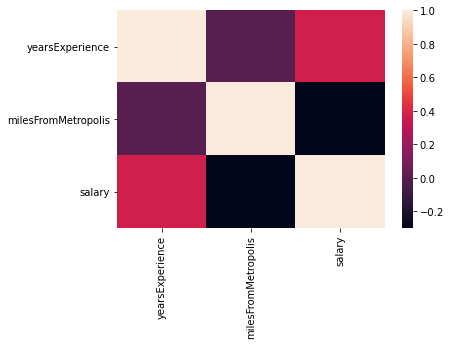

In [72]:
matrix =train_features.corr(method='pearson')
sns.heatmap(matrix)
plt.show()

Among the categorical features, it can be seen that using pearson correlation, yearsExperience is more correlated than milesFromMetroplois.

In [73]:
#for less and meaningful categories convert to binaryencoder
encoder = ce.BinaryEncoder(cols=['degree','major','jobType','industry','companyId'])
train_features_binary = encoder.fit_transform(train_features)
test_features_binary = encoder.fit_transform(test_features)
train_features.iloc[0]

jobId                  JOB1362684407687
companyId                        COMP37
jobType                             CFO
degree                          MASTERS
major                              MATH
industry                         HEALTH
yearsExperience                      10
milesFromMetropolis                  83
salary                              130
Name: 0, dtype: object

Handle the missing data using KNNImputer.

In [74]:
#most in janitor is missing
#both features are important, so we have to impute them
imputer = KNNImputer(n_neighbors=3)
train_features_binary = train_features_binary.drop(columns=["jobId"])
imputed_data = imputer.fit_transform(train_features_binary)
imputed_df = pd.DataFrame(imputed_data, columns=train_features_binary.columns)

Now on handling misisng data, outliers must be handled

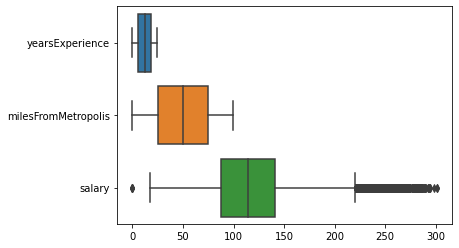

<Figure size 432x288 with 0 Axes>

In [75]:
df_continuous = imputed_df[['yearsExperience', 'milesFromMetropolis','salary']]

sns.boxplot(data=df_continuous, orient="h")
plt.show()
plt.savefig("outliers.png")

Target variable salary has outliers using box and whisker plot, bring to bounds from box whisker plot. Remove it by using maximum and minimum bounds to restrict them.

In [76]:
lower_salary = 17
upper_salary = 219
imputed_df.loc[imputed_df['salary'] > upper_salary, 'salary'] = upper_salary
imputed_df.loc[imputed_df['salary'] < lower_salary, 'salary'] = lower_salary

We then normalize the data using the standardScaler.

In [77]:
scaler = StandardScaler()
leave_target = imputed_df.drop('salary', axis=1)
scaled_values = scaler.fit_transform(leave_target.values)
scaled_features = pd.DataFrame(scaled_values, index = leave_target.index, columns = leave_target.columns)
scaled_features['salary']= imputed_df['salary']

Create a random forest regressor model and train the data

In [78]:
models = [('lr',LinearRegression()),('rfr',RFR(n_estimators=30, random_state=0))]
stacking = StackingRegressor(estimators=models)

Using cross validation, split the training data to train and test with 80% and 20% data accordingly.

In [79]:
k = 5
kf = KFold(n_splits=k, random_state=None)

rmse= []
r2 = []

for train_index , test_index in kf.split(scaled_features):
    train_X , test_X = scaled_features.iloc[train_index,:-1], scaled_features.iloc[test_index,:-1]
    train_Y , test_Y = scaled_features.iloc[train_index,-1], scaled_features.iloc[test_index,-1]
     
    stacking.fit(train_X, train_Y)
    pred = stacking.predict(test_X)
     
    rmse_score = mean_squared_error(test_Y,pred)
    rmse.append(rmse_score)
    r2_scores = r2_score(test_Y,pred)
    r2.append(r2_scores)
     
avg_rmse_score = sum(rmse)/k
avg_r2_score = sum(r2)/k
 
print('Avg RMSE: {}'.format(avg_rmse_score))
print('Avg R2: {}'.format(avg_r2_score))

Avg RMSE: 393.2560977254951
Avg R2: 0.733088346741451


Preprocess the test data in a manner similar to the training data.

In [54]:
test_features_binary = test_features_binary.drop(columns=["jobId"])
scaled_test = scaler.fit_transform(test_features_binary)
scaled_test_features = pd.DataFrame(scaled_test, index = imputed_df.index, columns = imputed_df.columns[:-1])
test_pred = stacking.predict(scaled_test_features)

In [55]:
predicted_salaries = pd.DataFrame(
    {'jobId': test_features["jobId"],
     'salary': test_pred
    })
predicted_salaries.to_csv("test_salaries.csv")